In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from keras import models, layers
import keras
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
from matplotlib import style

import cv2
import random as rn
import os

In [ ]:
X = []
TEMP = []
projectDir = '/content/drive/MyDrive/MACS/6505/Project'
IMG_SIZE = 32
nImagesOrg = projectDir + "/assets/normal/"
pImagesOrg = projectDir + "/assets/potholes/"

In [ ]:
def process_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            TEMP.append(str(label))
        except:
            pass

In [ ]:
process_data('NORMAL',nImagesOrg)

100%|██████████| 352/352 [00:08<00:00, 40.64it/s]


In [ ]:
process_data('POTHOLE',pImagesOrg)

100%|██████████| 329/329 [00:09<00:00, 33.79it/s]


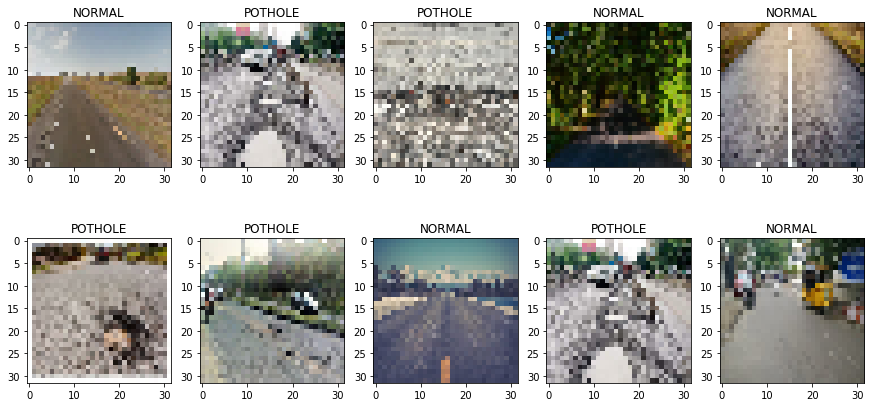

In [ ]:
fig,ax = plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(15,15)

for i in range(2):
    for j in range (5):
        l = rn.randint(0,len(TEMP))
        ax[i,j].imshow(X[l][:,:,::-1])
        ax[i,j].set_title(TEMP[l])
        ax[i,j].set_aspect('equal')

In [ ]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(TEMP)
Y = to_categorical(Y,2)
print(Y)
X = np.array(X)
X = X/255
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=0)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
X_train.shape

(510, 32, 32, 3)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-6)

In [ ]:
data_generator = ImageDataGenerator(
            rotation_range=10, 
            width_shift_range=0.1, 
            height_shift_range=0.1, 
            shear_range=0.1,
            zoom_range=0.2)
data_generator.fit(X_train) 

In [ ]:
class LeNet(models.Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape, padding="same"))
        self.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
        self.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
        self.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
        self.add(layers.Flatten())
        self.add(layers.Dense(84, activation='relu'))
        self.add(layers.Dense(num_classes, activation='softmax'))

        self.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(lr=5e-4))

In [ ]:
input_shape = (32, 32, 3)
num_classes = 2
batch_size = 32
epoch = 100
model = LeNet(input_shape, num_classes)
model_history = model.fit_generator(data_generator.flow(X_train, y_train, batch_size=100), steps_per_epoch=len(X_train)/100, 
                    epochs=100, validation_data=(X_test, y_test), callbacks=[reduce_lr])
test_score = model.evaluate(X_test, y_test, batch_size=batch_size)
print()
print('Test loss:', test_score[0]) 
print('Test accuracy:', test_score[1])

Epoch 1/100
5/5 [==============================] - 2s 345ms/step - loss: 0.6913 - accuracy: 0.5190 - val_loss: 0.6695 - val_accuracy: 0.4941
Epoch 2/100
5/5 [==============================] - 2s 364ms/step - loss: 0.6564 - accuracy: 0.6219 - val_loss: 0.6070 - val_accuracy: 0.6941
Epoch 3/100
5/5 [==============================] - 2s 368ms/step - loss: 0.5915 - accuracy: 0.7312 - val_loss: 0.5129 - val_accuracy: 0.7529
Epoch 4/100
5/5 [==============================] - 2s 310ms/step - loss: 0.5745 - accuracy: 0.6969 - val_loss: 0.4987 - val_accuracy: 0.7588
Epoch 5/100
5/5 [==============================] - 2s 315ms/step - loss: 0.5162 - accuracy: 0.7772 - val_loss: 0.5387 - val_accuracy: 0.7294
Epoch 6/100
5/5 [==============================] - 2s 304ms/step - loss: 0.4949 - accuracy: 0.7396 - val_loss: 0.4838 - val_accuracy: 0.7588
Epoch 7/100
5/5 [==============================] - 2s 305ms/step - loss: 0.5134 - accuracy: 0.7661 - val_loss: 0.5073 - val_accuracy: 0.7529

Epoch 00007:

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

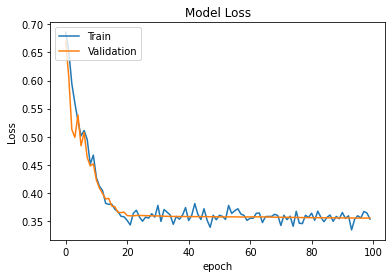

In [ ]:
plot_loss(model_history)
plt.show()

In [ ]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

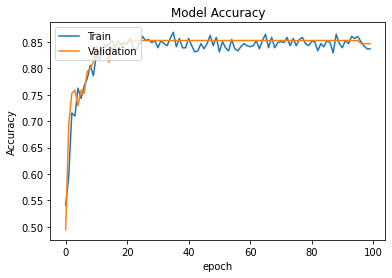

In [ ]:
plot_accuracy(model_history)
plt.show()

In [ ]:
model.summary()

Model: "le_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 6)         456       
_________________________________________________________________
average_pooling2d_2 (Average (None, 31, 31, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 16)        2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 120)         48120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 9720)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 84)                816

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(X_test)
matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print('Confusion Matrix:', matrix)
print('Classification Report:', classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

Confusion Matrix: [[68 16]
 [10 76]]
Classification Report:               precision    recall  f1-score   support

           0       0.87      0.81      0.84        84
           1       0.83      0.88      0.85        86

    accuracy                           0.85       170
   macro avg       0.85      0.85      0.85       170
weighted avg       0.85      0.85      0.85       170



**Visualization**

In [ ]:
import tensorflow as tf
import keras.backend as K

K.set_learning_phase(0)
logits = keras.models.Model(inputs=model.layers[0].input,outputs=model.layers[-2].output)
def visualize():
  print("Random Train Example")
  idx = rn.randint(0,len(X_train)-1)
  x_var = K.variable(X_train[idx:idx+1])
  with tf.GradientTape() as tape:
    tape.watch(x_var)
    y = tf.reduce_sum(logits(x_var)[:,label_encoder.transform(["POTHOLE"]).item()],axis=0)
  print(y)
  plt.axis("off")
  plt.imshow(x_var[0])
  plt.show()
  mask = tape.gradient(y,x_var)[0]
  plt.imshow(tf.reduce_sum(mask,axis=2))
  plt.show()

  print("Random Test Example")
  idx = rn.randint(0,len(X_test)-1)
  x_var = K.variable(X_test[idx:idx+1])
  with tf.GradientTape() as tape:
    tape.watch(x_var)
    y = tf.reduce_sum(logits(x_var)[:,label_encoder.transform(["POTHOLE"]).item()],axis=0)
  print(y)
  plt.axis("off")
  plt.imshow(x_var[0])
  plt.show()
  mask = tape.gradient(y,x_var)[0]
  plt.imshow(tf.reduce_sum(mask,axis=2))
  plt.show()

Random Train Example
tf.Tensor(0.28296113, shape=(), dtype=float32)


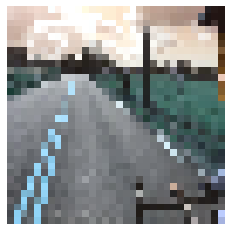

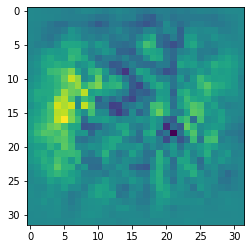

Random Test Example
tf.Tensor(0.32212603, shape=(), dtype=float32)


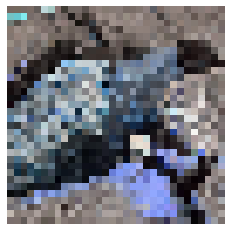

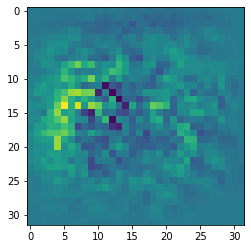

In [ ]:
visualize()